(arima_co2)=
# ARIMA-TimeSeries Analysis of Atmospheric CO<sub>2</sub>

This notebook is replicated from the blog https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3 This tutorial will require the warnings, itertools, pandas, numpy, matplotlib and statsmodels libraries. The warnings and itertools libraries come included with the standard Python library set so we shouldn't need to install them.

In this tutorial, we will aim to produce reliable forecasts of time series. We will begin by introducing and discussing the concepts of autocorrelation, stationarity, and seasonality, and proceed to apply one of the most commonly used method for time-series forecasting, known as ARIMA.

One of the methods available in Python to model and predict future points of a time series is known as **SARIMAX**, which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. Here, we will primarily focus on the ARIMA component, which is used to fit time-series data to better understand and forecast future points in the time series.

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import scipy.stats as scs
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Step 1 - Loading Time-series Data

We'll be working with a dataset called "Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.," which collected CO2 samples from March 1958 to December 2001. We can bring in this data as follows:

In [2]:
data = sm.datasets.co2.load_pandas()
df = data.data
df.head(5)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


Let's preprocess our data a little bit before moving forward. Weekly data can be tricky to work with since it’s a briefer amount of time, so let's use monthly averages instead. We’ll make the conversion with the *resample* function. For simplicity, we can also use the *fillna()* function to ensure that we have no missing values in our time series.

In [3]:
# The 'MS' string groups the data in buckets by start of the month
ts = df['co2'].resample('MS').mean()
ts.head(5)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

## Step 2 - Indexing with Time-series Data

In [4]:
ts.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2001-03-01', '2001-04-01', '2001-05-01', '2001-06-01',
               '2001-07-01', '2001-08-01', '2001-09-01', '2001-10-01',
               '2001-11-01', '2001-12-01'],
              dtype='datetime64[ns]', length=526, freq='MS')

With our data properly indexed for working with temporal data, we can move onto handling values that may be missing.

## Step 3 - Handling Missing Values in Time-series Data

Real world data tends be messy. As we can see from the plot, it is not uncommon for time-series data to contain missing values. The simplest way to check for those is either by directly plotting the data or by using the command below that will reveal missing data.

In [5]:
ts.isnull().sum()

5

This output tells us that there are 5 months with missing values in our time series.

Generally, we should "fill in" missing values if they are not too numerous so that we don’t have gaps in the data. We can do this in pandas using the *fillna()* command. For simplicity, we can fill in missing values with the closest non-null value in our time series, although it is important to note that a rolling mean would sometimes be preferable.

In [6]:
# The term bfill means that we use the value before filling in missing values
ts = ts.fillna(ts.bfill())
ts.head(5)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

With missing values filled in, we can once again check to see whether any null values exist to make sure that our operation worked:

In [7]:
ts.isnull().sum()

0

After performing these operations, we see that we have successfully filled in all missing values in our time series.

## Step 4 - Visualizing Time-series Data

When working with time-series data, a lot can be revealed through visualizing it. A few things to look out for are:

+ **seasonality:** does the data display a clear periodic pattern?
+ **trend:** does the data follow a consistent upwards or downward slope?
+ **noise:** are there any outlier points or missing values that are not consistent with the rest of the data?

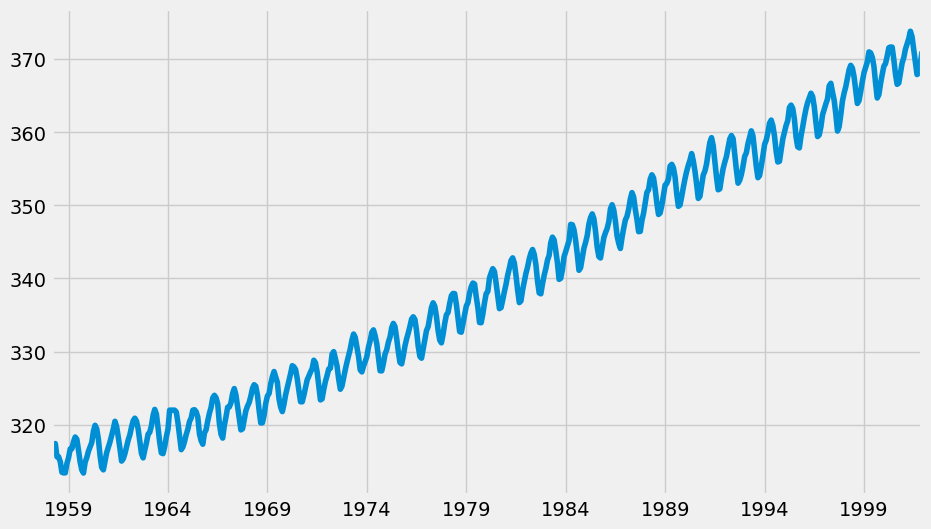

In [8]:
plt.close()
ts.plot(figsize=(10, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has an obvious seasonality pattern, as well as an overall increasing trend. We can also visualize our data using a method called time-series decomposition. As its name suggests, time series decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

Fortunately, *statsmodels* provides the convenient *seasonal_decompose* function to perform seasonal decomposition out of the box.

In [9]:
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')

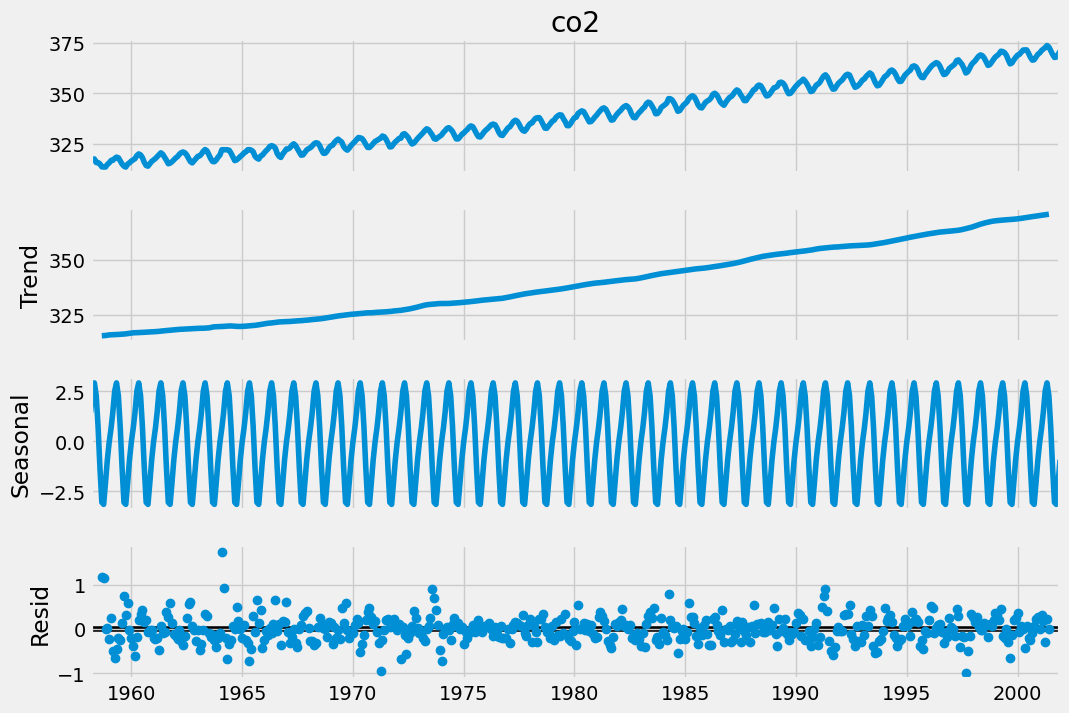

In [10]:
from pylab import rcParams
#rcParams['figure.figsize'] = 12, 10
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. The plot above clearly shows the upwards trend of our data, along with its yearly seasonality. These can be used to understand the structure of our time-series. The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts.

## Step 5 - The ARIMA Time Series Model
One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **A**uto**R**egressive **I**ntegrated **M**oving **A**verage. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

+ **p** is the *auto-regressive* part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.


+ **d** is the *integrated* part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.


+ **q** is the *moving average* part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

## Step 6 - Parameter Selection for the ARIMA Time Series Model

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Other statistical programming languages such as R provide automated ways to solve this issue, but those have yet to be ported over to Python. In this section, we will resolve this issue by writing Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let's begin by generating the various combination of parameters that we wish to assess:

In [11]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [12]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            model = sm.tsa.statespace.SARIMAX(ts,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23439D+00    |proj g|=  7.60014D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.600D-07   7.234D+00
  F =   7.2343948953241553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76139D+00    |proj g|=  1.67403D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   2.398D-06   1.761D+00
  F =   1.7612435685753014     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00474D+00    |proj g|=  1.83808D+01

At iterate    5    f=  1.00373D+00    |proj g|=  1.57826D+01

At iterate   10    f=  9.99143D-01    |proj g|=  2.79266D+00

At iterate   15    f=  9.99122D-01    |proj g|=  6.58317D-01

At iterate   20    f=  9.98505D-01    |proj g|=  2.85694D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     37      1     0     0   4.561D-02   9.984D-01
  F =  0.99837247469289803     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64984D+00    |proj g|=  6.32635D+00

At iterate    5    f=  1.06258D+00    |proj g|=  6.84074D-01

At iterate   10    f=  9.89327D-01    |proj g|=  2.25647D-01

At iterate   15    f=  9.87419D-01    |proj g|=  5.74224D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     24      1     0     0   5.742D-05   9.874D-01
  F =  0.98741900310722308     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.85235D+00    |proj g|=  2.18895D-03

At iterate   15    f=  6.57093D+00    |proj g|=  4.23496D-01

At iterate   20    f=  6.54097D+00    |proj g|=  1.94114D-01

At iterate   25    f=  6.53712D+00    |proj g|=  5.96637D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     53      1     0     0   5.966D-05   6.537D+00
  F =   6.5371185884611869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41353D+00    |proj g|=  3.92879D-01

At iterate    5    f=  1.17437D+00    |proj g|=  6.70076D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   4.572D-07   1.174D+00
  F =   1.1743512088242587     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   20    f=  2.23406D+00    |proj g|=  9.96928D+01

At iterate   25    f=  1.67349D+00    |proj g|=  2.68443D+01

At iterate   30    f=  1.31701D+00    |proj g|=  1.45833D+01

At iterate   35    f=  1.15652D+00    |proj g|=  3.26810D+00

At iterate   40    f=  1.08308D+00    |proj g|=  1.45794D+00

At iterate   45    f=  1.05186D+00    |proj g|=  3.64533D+00

At iterate   50    f=  1.03136D+00    |proj g|=  4.20948D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50    124      1     2     0   4.209D+00   1.031D+00
  F =   1.0313622689201409     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  6.56200D+00    |proj g|=  2.51630D-02

At iterate   10    f=  6.53258D+00    |proj g|=  3.36347D-02

At iterate   15    f=  6.52695D+00    |proj g|=  1.09277D-01

At iterate   20    f=  4.48318D+00    |proj g|=  1.92231D+01

At iterate   25    f=  2.69118D+00    |proj g|=  1.51246D+01

At iterate   30    f=  1.09886D+00    |proj g|=  2.94409D+01

At iterate   35    f=  7.54465D-01    |proj g|=  5.51364D+00

At iterate   40    f=  7.43590D-01    |proj g|=  1.04524D+01

At iterate   45    f=  7.34269D-01    |proj g|=  8.19933D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48    130   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.05857D+00    |proj g|=  5.86792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   2.538D-06   1.059D+00
  F =   1.0585511305718003     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38037D+00    |proj g|=  8.40437D-01

At iterate    5    f=  8.24061D-01    |proj g|=  2.82783D-01

At iterate   10    f=  7.62149D-01    |proj g|=  1.17543D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.17359D-01    |proj g|=  5.16061D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     17      1     0     0   1.428D-05   3.173D-01
  F =  0.31729453891968556     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85504D-01    |proj g|=  4.86125D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.52599D-01    |proj g|=  5.39603D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     33      1     0     0   6.786D-05   3.526D-01
  F =  0.35259351327468280     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50884D-01    |proj g|=  4.90921D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.17925D-01    |proj g|=  2.60638D-01

At iterate   10    f=  3.01720D-01    |proj g|=  1.46124D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     43      1     0     0   1.998D-03   3.016D-01
  F =  0.30163940447868709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43891D+00    |proj g|=  1.95608D+00

At iterate    5    f=  1.29961D+00    |proj g|=  2.04841D-03

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.04172D+00    |proj g|=  1.23976D-02

At iterate   10    f=  1.04167D+00    |proj g|=  1.99036D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   1.990D-06   1.042D+00
  F =   1.0416740241733069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56081D-01    |proj g|=  8.47704D-02

At iterate    5    f=  5.55084D-01    |proj g|=  8.00686D-06

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.85305D-01    |proj g|=  3.64860D-01

At iterate   10    f=  2.81840D-01    |proj g|=  1.42595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     22      1     0     0   4.210D-05   2.818D-01
  F =  0.28183925868295212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37809D+00    |proj g|=  2.28191D+00

At iterate    5    f=  5.52206D-01    |proj g|=  1.10142D-01

At iterate   10    f=  5.49842D-01    |proj g|=  6.52491D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     18      1     0     0   6.525D-06   5.498D-01
  F =  0.54984159058532434     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  4.05976D-01    |proj g|=  1.28001D-03

At iterate   10    f=  4.05976D-01    |proj g|=  5.14006D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     16      1     0     0   5.140D-07   4.060D-01
  F =  0.40597562814369031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53731D-01    |proj g|=  8.34383D-01


 This problem is unconstrained.



At iterate    5    f=  2.80420D-01    |proj g|=  4.65724D-01

At iterate   10    f=  2.62224D-01    |proj g|=  2.51609D-02
  ys=-4.430E-03  -gs= 1.826E-04 BFGS update SKIPPED

At iterate   15    f=  2.60035D-01    |proj g|=  7.45522D-03

At iterate   20    f=  2.60013D-01    |proj g|=  1.39475D-01

At iterate   25    f=  2.59999D-01    |proj g|=  1.82309D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     62      1     1     0   2.491D-04   2.600D-01
  F =  0.25999906664508654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.39003D+00    |proj g|=  1.82266D+01

At iterate   10    f=  1.37228D+00    |proj g|=  4.59474D-01

At iterate   15    f=  1.36651D+00    |proj g|=  6.82478D+00

At iterate   20    f=  1.18204D+00    |proj g|=  1.39730D+00

At iterate   25    f=  1.17484D+00    |proj g|=  2.42446D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     85      2     0     0   2.030D-01   1.175D+00
  F =   1.1748430455430507     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89601D-01    |proj g|=  4.70562D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13553D+00    |proj g|=  7.02833D-01

At iterate    5    f=  5.89027D-01    |proj g|=  1.02577D+00

At iterate   10    f=  5.56547D-01    |proj g|=  4.36791D-01

At iterate   15    f=  5.45047D-01    |proj g|=  1.08790D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     45      1     0     0   8.664D-02   5.450D-01
  F =  0.54504723825171464     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  5.00407D-01    |proj g|=  4.01634D-01

At iterate   10    f=  4.60487D-01    |proj g|=  1.22399D+01

At iterate   15    f=  4.35467D-01    |proj g|=  2.36315D-01

At iterate   20    f=  4.32848D-01    |proj g|=  1.24401D+00

At iterate   25    f=  3.73148D-01    |proj g|=  7.18683D+00

At iterate   30    f=  3.45629D-01    |proj g|=  1.01414D+00

At iterate   35    f=  3.44669D-01    |proj g|=  1.51775D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     68      1     0     0   1.207D-04   3.447D-01
  F =  0.34466925453774788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04621D-01    |proj g|=  4.54004D-01

At iterate    5    f=  4.39859D-01    |proj g|=  1.23700D+00

At iterate   10    f=  3.13141D-01    |proj g|=  4.99781D-01

At iterate   15    f=  3.05690D-01    |proj g|=  6.57276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   5.273D-06   3.057D-01
  F =  0.30568868742482641     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74496D+00    |proj g|=  6.05778D+01

At iterate    5    f=  1.35526D+00    |proj g|=  6.37256D+00

At iterate   10    f=  1.34955D+00    |proj g|=  1.77187D+00

At iterate   15    f=  1.31900D+00    |proj g|=  3.39753D+01

At iterate   20    f=  1.29950D+00    |proj g|=  4.04779D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     40      1     0     0   6.888D-02   1.299D+00
  F =   1.2990575933126030     

CONVERG


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     81      2     0     0   8.269D-02   1.133D+00
  F =   1.1325939277577102     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53171D-01    |proj g|=  4.79301D-02

At iterate    5    f=  5.51757D-01    |proj g|=  2.09975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91670D+00    |proj g|=  5.15561D+00

At iterate    5    f=  1.07143D+00    |proj g|=  8.46950D+00

At iterate   10    f=  8.49397D-01    |proj g|=  1.18961D+00

At iterate   15    f=  6.39751D-01    |proj g|=  3.93768D+00

At iterate   20    f=  5.78767D-01    |proj g|=  1.02668D+01

At iterate   25    f=  5.76011D-01    |proj g|=  9.12856D-01

At iterate   30    f=  5.72187D-01    |proj g|=  1.44567D+01

At iterate   35    f=  5.60422D-01    |proj g|=  3.99215D+00

At iterate   40    f=  5.56742D-01    |proj g|=  1.85065D+00

At iterate   45    f=  5.52457D-01    |proj g|=  9.95261D-01

At iterate   50    f=  5.50359D-01    |proj g|=  1.16832D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  5.61683D-01    |proj g|=  2.47182D+01

At iterate   20    f=  5.37446D-01    |proj g|=  1.06561D+00

At iterate   25    f=  5.21169D-01    |proj g|=  1.73202D+01

At iterate   30    f=  4.27326D-01    |proj g|=  2.01845D+00

At iterate   35    f=  3.74317D-01    |proj g|=  5.19091D-01

At iterate   40    f=  3.70075D-01    |proj g|=  9.67651D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     73      1     0     0   4.728D-02   3.700D-01
  F =  0.36996695775358679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  4.04513D-01    |proj g|=  2.31878D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   2.634D-05   4.045D-01
  F =  0.40451230651500530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68407D-01    |proj g|=  5.00450D-01


 This problem is unconstrained.



At iterate    5    f=  4.23350D-01    |proj g|=  1.40209D+00

At iterate   10    f=  2.69696D-01    |proj g|=  2.69156D-01

At iterate   15    f=  2.62263D-01    |proj g|=  2.53474D-01

At iterate   20    f=  2.62192D-01    |proj g|=  5.47033D-02

At iterate   25    f=  2.62156D-01    |proj g|=  1.76356D-01

At iterate   30    f=  2.62134D-01    |proj g|=  1.08576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     45      1     0     0   8.374D-06   2.621D-01
  F =  0.26213420037902013     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67245D-01    |proj g|=  5.78685D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   5.787D-05   5.672D-01
  F =  0.56724455158927878     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.6

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73905D-01    |proj g|=  5.91870D-01

At iterate    5    f=  5.75350D-01    |proj g|=  3.56607D-01

At iterate   10    f=  5.58616D-01    |proj g|=  4.16162D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     22      1     0     0   4.300D-05   5.586D-01
  F =  0.55861575615119885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71434D-01    |proj g|=  8.61170D-01

At iterate    5    f=  2.88784D-01    |proj g|=  2.03588D-01

At iterate   10    f=  2.71849D-01    |proj g|=  6.64934D-02

At iterate   15    f=  2.71624D-01    |proj g|=  3.02477D-03

At iterate   20    f=  2.71618D-01    |proj g|=  6.35641D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     38      1     0     0   6.356D-05   2.716D-01
  F =  0.27161846226812553     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.92456D-01    |proj g|=  1.12881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   3.629D-07   9.925D-01
  F =  0.99245596236313471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47111D-01    |proj g|=  6.20448D-02

At iterate    5    f=  5.46873D-01    |proj g|=  1.74028D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  2.77557D-01    |proj g|=  3.74628D-01

At iterate   10    f=  2.73914D-01    |proj g|=  9.34579D-03

At iterate   15    f=  2.73705D-01    |proj g|=  1.69473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   1.016D-05   2.737D-01
  F =  0.27370475827843971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03352D+00    |proj g|=  4.96954D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.40899D-01    |proj g|=  4.30805D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   1.522D-05   5.407D-01
  F =  0.54074592318330217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34434D-01    |proj g|=  6.56452D-01

At iterate    5    f=  4.37568D-01    |proj g|=  1.08058D+00

At iterate   10    f=  3.11880D-01    |proj g|=  2.78467D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14567D-01    |proj g|=  5.15497D-01

At iterate    5    f=  3.99925D-01    |proj g|=  9.68833D-03

At iterate   10    f=  3.99812D-01    |proj g|=  2.66387D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     17      1     0     0   2.651D-06   3.998D-01
  F =  0.39981222748228579     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49067D-01    |proj g|=  8.40987D-01

At iterate    5    f=  2.76116D-01    |proj g|=  4.65685D-01

At iterate   10    f=  2.57264D-01    |proj g|=  2.41837D-02

At iterate   15    f=  2.54554D-01    |proj g|=  4.62866D-03

At iterate   20    f=  2.54547D-01    |proj g|=  4.49631D-03

At iterate   25    f=  2.54544D-01    |proj g|=  2.25757D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     76      2     0     0   1.091D-04   2.545D-01
  F =  0.25454393504719697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best SARIMAX(1, 1, 1)x(1, 1, 1, 12)12 model - AIC:277.7802196696512



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Because some parameter combinations may lead to numerical misspecifications, we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we make sure to catch these exceptions and ignore the parameter combinations that cause these issues.

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

## Step 5 — Fitting an ARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model:

In [13]:
best_model = sm.tsa.statespace.SARIMAX(ts,
                                      order=(1, 1, 1),
                                      seasonal_order=(1, 1, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
results = best_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49067D-01    |proj g|=  8.40987D-01


 This problem is unconstrained.



At iterate    5    f=  2.76116D-01    |proj g|=  4.65685D-01

At iterate   10    f=  2.57264D-01    |proj g|=  2.41837D-02

At iterate   15    f=  2.54554D-01    |proj g|=  4.62866D-03

At iterate   20    f=  2.54547D-01    |proj g|=  4.49631D-03

At iterate   25    f=  2.54544D-01    |proj g|=  2.25757D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     76      2     0     0   1.091D-04   2.545D-01
  F =  0.25454393504719697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [14]:
print(results.summary().tables[0])
print(results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -133.890
Date:                            Thu, 04 Apr 2024   AIC                            277.780
Time:                                    08:24:17   BIC                            298.843
Sample:                                03-01-1958   HQIC                           286.046
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077   

The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

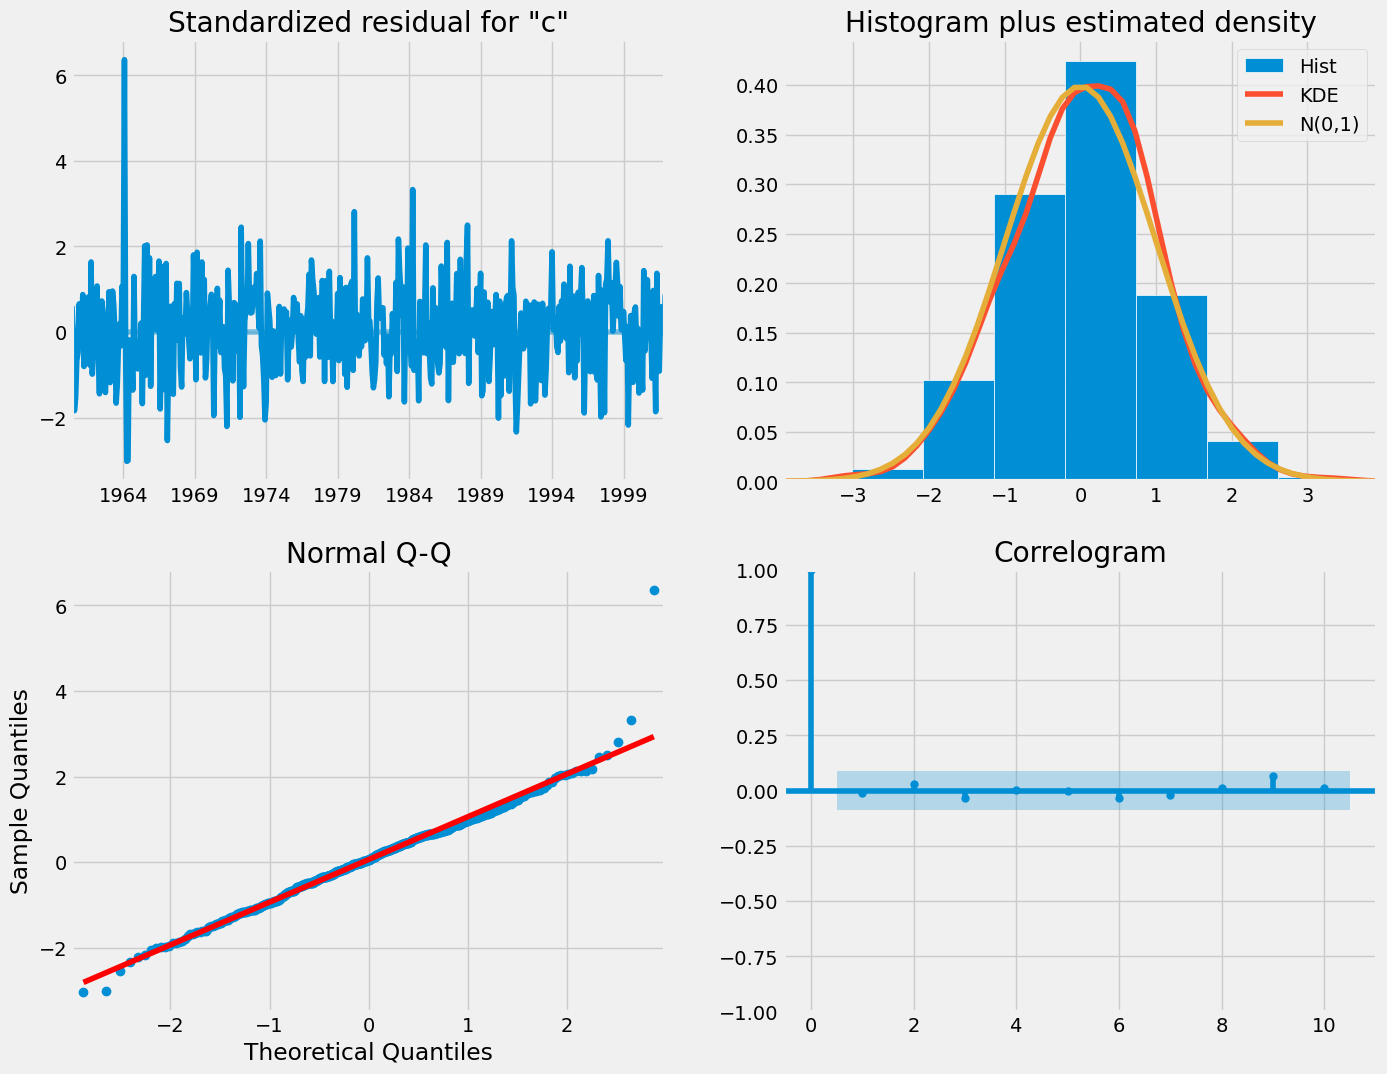

In [15]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

+ In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

+ The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

+ The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

## Step 6 - Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [16]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [17]:
pred_ci.head(5)

,lower co2,upper co2
1998-01-01,364.453370,365.675245
1998-02-01,365.373505,366.595380
1998-03-01,366.404746,367.626621
1998-04-01,367.908504,369.130378
1998-05-01,368.389525,369.611399


The code above requires the forecasts to start at January 1998.

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

We can plot the real and forecasted values of the CO<sub>2</sub> time series to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index.

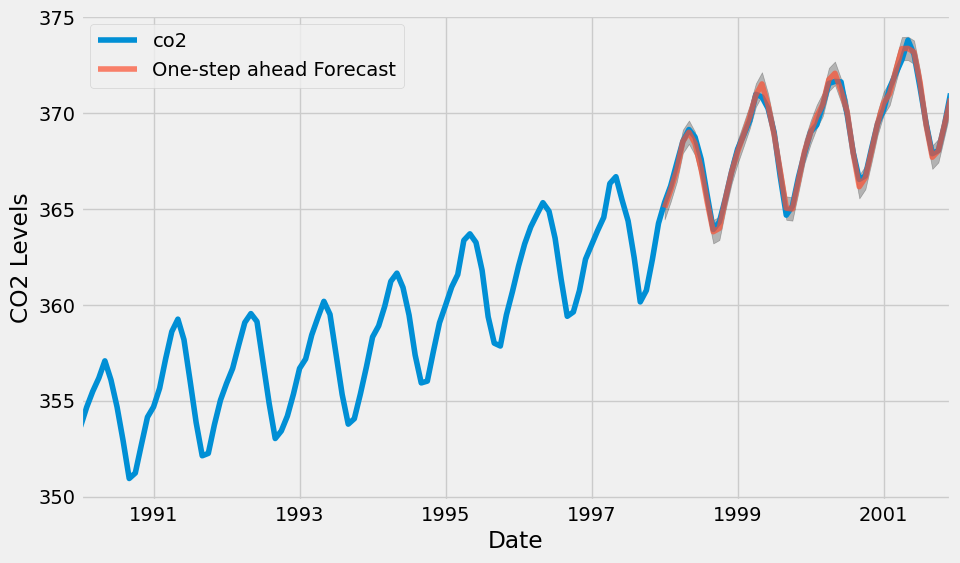

In [18]:
plt.close()
axis = ts['1990':].plot(figsize=(10, 6))
pred.predicted_mean.plot(ax=axis, label='One-step ahead Forecast', alpha=0.7)
axis.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
axis.set_xlabel('Date')
axis.set_ylabel('CO2 Levels')
plt.legend(loc='best')
plt.show()

Overall, our forecasts align with the true values very well, showing an overall increase trend.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [19]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['1998-01-01':]

# Compute the mean sqaure error
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from January 1998 onwards.

In [20]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynami_ci = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.

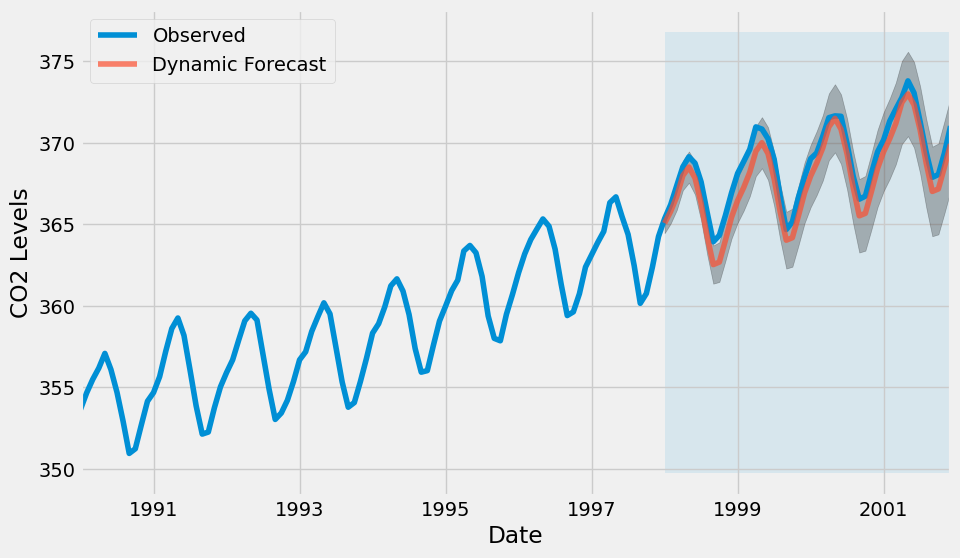

In [21]:
axis = ts['1990':].plot(label='Observed', figsize=(10, 6))
pred_dynamic.predicted_mean.plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynami_ci.index, pred_dynami_ci.iloc[:, 0], pred_dynami_ci.iloc[:, 1], color='k', alpha=.25)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('1998-01-01'), ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Date')
axis.set_ylabel('CO2 Levels')
plt.legend(loc='best')
plt.show()
plt.close()

Once again, we quantify the predictive performance of our forecasts by computing the MSE:

In [22]:
# Extract the predicted and true values of our time series
ts_forecasted = pred_dynamic.predicted_mean
ts_truth = ts['1998-01-01':]

# Compute the mean square error
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


The predicted values obtained from the dynamic forecasts yield an MSE of 1.01. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.

## Step 7 - Producing and Visualizing Forecasts

In the final step of this tutorial, we describe how to leverage our seasonal ARIMA time series model to forecast future values. The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [23]:
# Get forecast 500 steps ahead in future
n_steps = 500
pred_uc_99 = results.get_forecast(steps=500, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = results.get_forecast(steps=500, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals of forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [24]:
n_steps = 500
idx = pd.date_range(ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2001-12-01,371.977655,371.366719,371.366719,372.588590,372.588590
2002-01-01,372.749096,372.005879,372.005879,373.492312,373.492312
2002-02-01,373.662307,372.834952,372.834952,374.489661,374.489661
2002-03-01,374.859621,373.963403,373.963403,375.755839,375.755839
2002-04-01,375.345756,374.387754,374.387754,376.303759,376.303759


We can use the output of this code to plot the time series and forecasts of its future values.

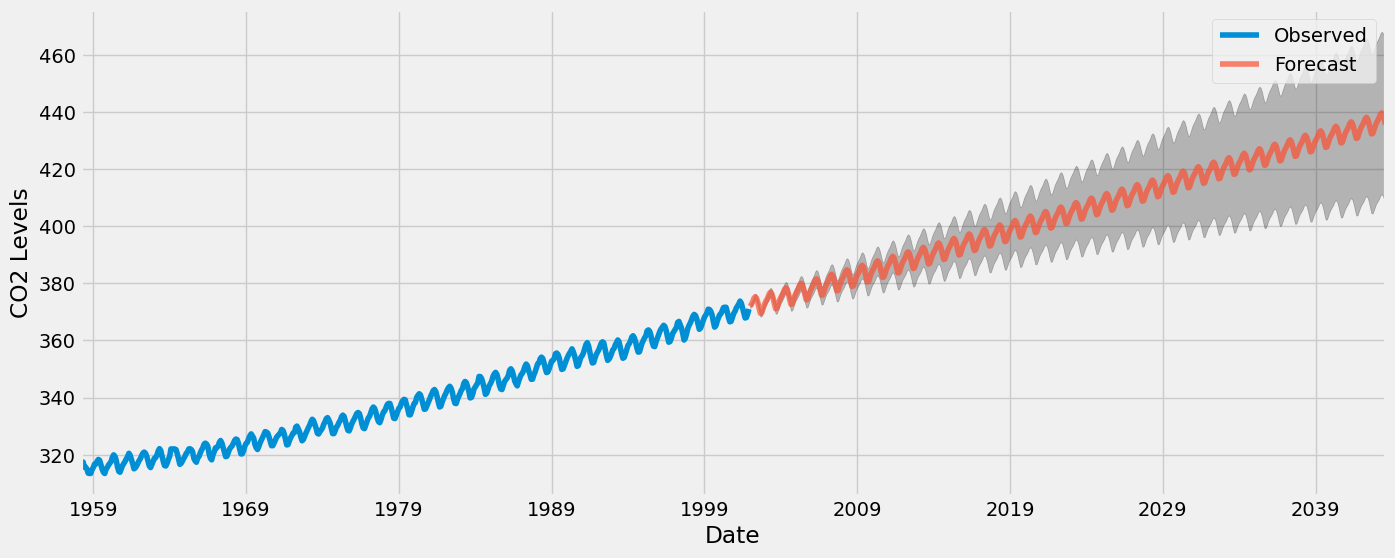

In [25]:
plt.close()
axis = ts.plot(label='Observed', figsize=(15, 6))
pred_uc_95.predicted_mean.plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(pred_ci_95.index, pred_ci_95.iloc[:, 0], pred_ci_95.iloc[:, 1], color='k', alpha=.25)
#axis.fill_between(pred_ci_99.index, pred_ci_99.iloc[:, 0], pred_ci_99.iloc[:, 1], color='b', alpha=.25)
axis.set_xlabel('Date')
axis.set_ylabel('CO2 Levels')
plt.legend(loc='best')
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.